In [7]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [8]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [10]:
def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

In [5]:
df = pd.DataFrame({"drought":count, "drought1":count})
#df.drought1 = df.drought1.shift(abs(tau))

In [153]:
df

drought  drought1
6         56      54.0
7         53      38.0
8         46      42.0
9         54      43.0
10        35      53.0
..       ...       ...
463       26      19.0
464       39      22.0
465       61      22.0
466       87      13.0
467       82      12.0

[462 rows x 2 columns]

In [150]:
df.drought1 = df.drought1.shift(abs(tau))

In [152]:
df = df.dropna()

In [11]:
def min_MSE_finder(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)

In [35]:
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

NameError: name 'feat_labels' is not defined

In [52]:
l = np.concatenate([[0],link[:,0]])   

In [54]:
for feature in zip(l, model.feature_importances_):
    print(feature)

(0, 0.1995886283218169)
(2, 0.02367270506119166)
(0, 0.06421411154562275)
(41, 0.017304961359712986)
(72, 0.05911186268694704)
(22, 0.020663238730278262)
(52, 0.03306620666984526)
(18, 0.024218071369737366)
(58, 0.026500066491330423)
(46, 0.019357489856481426)
(38, 0.04416022300636808)
(54, 0.03656154286517217)
(52, 0.01983481227615351)
(0, 0.0275392603265719)
(14, 0.041695211927482184)
(43, 0.013062209636370382)
(64, 0.02256865389421504)
(8, 0.013549490476610311)
(17, 0.03775793867319704)
(29, 0.044697632818490395)
(68, 0.016281208884116688)
(5, 0.02112067436263555)
(39, 0.03123610208352041)
(70, 0.038160873229520796)
(67, 0.026015162002725228)
(23, 0.07806166144388615)


In [68]:
sfm = SelectFromModel(model, threshold=0.03)

# Train the selector
sfm.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.03)

In [69]:
for feature_list_index in sfm.get_support(indices=True):
    print(l[feature_list_index])

0
0
72
52
38
54
14
17
29
39
70
23


In [70]:
link_list[-1]

array([[  2, -12],
       [ 22,  -8],
       [ 38,  -8],
       [ 14,  -6],
       [  5,  -8],
       [ 52,  -7],
       [ 33,  -8],
       [ 72,  -6]])

In [72]:
X_important_train = sfm.transform(x_train)
X_important_test = sfm.transform(x_test)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [74]:
model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
model.fit(X_important_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [75]:
pred = model.predict(X_important_test)

In [76]:
mean_squared_error(pred, y_test)

1101.7610218978102

In [78]:
X_important_train.shape

(319, 12)

In [80]:
x_train.shape

(319, 26)

In [47]:
df

drought  drought1          1          0        71         21        51  \
12        30      56.0  -7.848510 -32.090067  2.501697 -10.442174 -4.607464   
13        32      53.0 -15.507652 -33.805287  1.194513  -3.395298 -1.278549   
14        30      46.0 -25.191986 -33.789085 -5.173244   3.936284 -4.045571   
15        30      54.0 -23.034614 -39.643698  2.627116   5.827090 -4.432507   
16        10      35.0  -9.125324 -50.933960 -2.245497   0.311090 -3.866423   
..       ...       ...        ...        ...       ...        ...       ...   
463       26      19.0  37.891602  41.295770 -4.049258  -0.609931 -2.930765   
464       39      22.0  44.742732  32.659996 -3.572740   4.294890 -6.334464   
465       61      22.0  48.279216  29.818583 -1.068578   5.468780 -4.665835   
466       87      13.0  44.709146  26.798429  1.188654   8.302684 -9.076751   
467       82      12.0  43.486255  19.928794 -3.695036   0.626912 -1.712430   

           45         37        53  ...        69        66         48  \
12   6.617290   0.731460  3.544888  ...  4.420876 -0.780401  -9.489008   
13   1.482331   0.640374  7.680445  ...  0.601129  0.167031  -7.780473   
14   3.634326   3.440546  6.156192  ...  1.025415 -2.389673   0.421260   
15  -0.202362  -0.452660  2.644330  ...  1.575400  3.623447 -10.018381   
16   9.014560  -3.729907 -3.011562  ... -2.191914  0.730964  -7.624721   
..        ...        ...       ...  ...       ...       ...        ...   
463  8.441176  15.843592  2.518079  ... -0.390123  1.225226   0.471543   
464  7.850148   6.371389  5.771152  ... -0.610630  3.934813   7.498389   
465  2.551322   3.939041  7.124292  ... -1.309641  3.207812   5.142617   
466  3.635500  -3.428577  0.902686  ...  0.323008 -2.759140   4.981946   
467 -1.509472   1.456351 -2.490013  ... -2.163352 -5.980879   2.636653   

           33         47          9         32        56        70         20  
12  -6.477748  -4.638579  -4.075037   8.669991 -1.872487  5.342207  13.001574  
13   3.929093  -1.280201 -14.810717   3.760026 -0.553211 -7.059296  14.774901  
14   5.877221  -1.796025 -11.831072  -1.687085  3.221561 -4.608638  13.933919  
15  -0.594296   8.986806  -8.095282  -4.203653  0.330763  2.605545   8.934140  
16   4.823333  13.138742   2.607435 -10.129449  0.439591  4.984782  16.041614  
..        ...        ...        ...        ...       ...       ...        ...  
463  3.108076   8.250733  20.417684   1.489946  1.773995  0.209325  -3.878995  
464  5.939232   6.050256   5.971491  -6.561787  0.132472  2.212657 -14.270347  
465  3.392673   2.384707   4.579384  -8.046635  4.106464  0.133364 -17.176654  
466  8.707619  -0.713550  16.909306  -8.875126  7.611166 -3.998548 -10.075500  
467  9.212934  -0.149802  22.177668 -12.806471  2.896845  1.346221  -6.729175  

[456 rows x 27 columns]

In [16]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc","../../nc/pres.mon.mean.nc","../../nc/air.mon.mean.nc","../../nc/sst.mnmean.nc"]
code = ["precip", "pres", "air", "sst"]
missing = [-9.96921e+36, -9.96921e+36, -9.96921e+36,-9.96921e+36]
n_components = [87, 64, 82, 76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]
               
    data = pd.DataFrame(result)

    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(scaled_data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)
    
pres_name  = []
for i in range(n_components[1]):
    pres_name.append("PRES_%d"%i)
    
sat_name  = []
for i in range(n_components[2]):
    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[3]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name + pres_name + sat_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))
result_precip = np.array(df_cluster[0])
result_pres = np.array(df_cluster[1])
result_sat = np.array(df_cluster[2])
result_sst = np.array(df_cluster[3])


result = np.concatenate((result_extremes,result_precip, result_pres, result_sat, result_sst), axis=1)
result = np.array(result)

In [8]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()

In [9]:
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [7]:
#results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [5]:
results = load_obj("results")

In [6]:
q_matrix = np.load("q_matrix.npy")

In [10]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 42 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.587
        (PRECIP_1 -1): pval = 0.00023 | val = 0.196
        (SAT_70 -1): pval = 0.00055 | val = 0.188
        (PRECIP_39 -1): pval = 0.00068 | val = 0.185
        (SAT_62 -1): pval = 0.00182 | val = -0.172
        (PRECIP_5 -1): pval = 0.00197 | val = 0.171
        (SST_60 -2): pval = 0.00210 | val = -0.168
        (PRECIP_49 -2): pval = 0.00280 | val = -0.165
        (PRES_29 -1): pval = 0.00375 | val = 0.158
        (PRECIP_13 -1): pval = 0.00508 | val = -0.155
        (PRES_32 -2): pval = 0.00491 | val = -0.154
        (PRES_32 -1): pval = 0.00492 | val = 0.154
        (PRECIP_11 -1): pval = 0.01009 | val = 0.142
        (PRECIP_78 -2): pval = 0.01073 | val = -0.142
        (SST_29 -1): pval = 0.01012 | val = -0.141
        (PRECIP_43 -2): pval = 0.01330 | val = -0.139
        (SST_41 -2): pval = 0.01254 | val = 0.138
        (PRES_46 -1): pval = 0.01

In [11]:
#q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.587

    Variable PRECIP_0 has 1 link(s):
        (SAT_7 -1): pval = 0.00002 | qval = 0.02883 | val = -0.236

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 1 link(s):
        (PRECIP_60 -1): pval = 0.00001 | qval = 0.01316 | val = -0.242

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 0 link(s):

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 1 link(s):
        (PRECIP_51 -

In [12]:
def min_MSE_finder1(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]
    refined_link = []
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_pred, y_test)
        if mse < result[-1]:
            result.append(mean_squared_error(y_pred, y_test))
            refined_link.append(link[z])
    return(result,np.array(refined_link))

In [13]:
name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sst_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


In [14]:
result_sst = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results = load_obj("results_st")

q_matrix = np.load("q_matrix_sst.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.393
        (SST_1 -12): pval = 0.00003 | val = -0.230
        (n_extremes -12): pval = 0.00005 | val = -0.229
        (SST_40 -1): pval = 0.00022 | val = -0.213
        (SST_71 -11): pval = 0.00261 | val = 0.176
        (SST_21 -8): pval = 0.00233 | val = 0.175
        (SST_51 -10): pval = 0.00275 | val = 0.174
        (SST_17 -3): pval = 0.00359 | val = 0.168
        (SST_57 -4): pval = 0.00345 | val = 0.168
        (SST_45 -11): pval = 0.00725 | val = -0.156
        (SST_37 -8): pval = 0.01098 | val = 0.146
        (SST_53 -6): pval = 0.01228 | val = -0.144
        (SST_51 -2): pval = 0.01312 | val = 0.143
        (n_extremes -11): pval = 0.01259 | val = 0.142
        (SST_13 -6): pval = 0.01494 | val = 0.140
        (SST_42 -11): pval = 0.01589 | val = 0.140
        (SST_63 -4): pval = 0.01636 | val = 0.138
        (SST_7 -12): pval = 0.01736 | val = 0.1

# First Approach

In [184]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)


In [224]:
n_estimators=100
max_depth=100
tau = -3

In [225]:
link = np.array(link_dict[0])
link = link[1:,: ]

In [207]:
#np.random.shuffle(link)

In [226]:
link[link[:,1]<=tau]

array([[  2, -12],
       [  0, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 52, -10],
       [ 18,  -3],
       [ 58,  -4],
       [ 46, -11],
       [ 38,  -8],
       [ 54,  -6],
       [  0, -11],
       [ 14,  -6],
       [ 43, -11],
       [ 64,  -4],
       [  8, -12],
       [ 17,  -7],
       [ 29, -10],
       [  5,  -8],
       [ 39, -10],
       [ 70,  -6],
       [ 67,  -9],
       [ 23,  -5],
       [ 52,  -7],
       [ 49,  -6],
       [ 67, -12],
       [ 75,  -4],
       [  1,  -4],
       [ 34, -11],
       [ 48, -10],
       [  6,  -5],
       [ 40,  -4],
       [ 10,  -7],
       [ 33,  -8],
       [ 57,  -6],
       [ 72,  -6],
       [  1, -10],
       [ 71,  -6],
       [ 67,  -6],
       [ 21,  -7],
       [ 14,  -3],
       [  2, -11]])

In [227]:
#np.random.shuffle(link[1:,:])

result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

Text(0, 0.5, 'MSE')

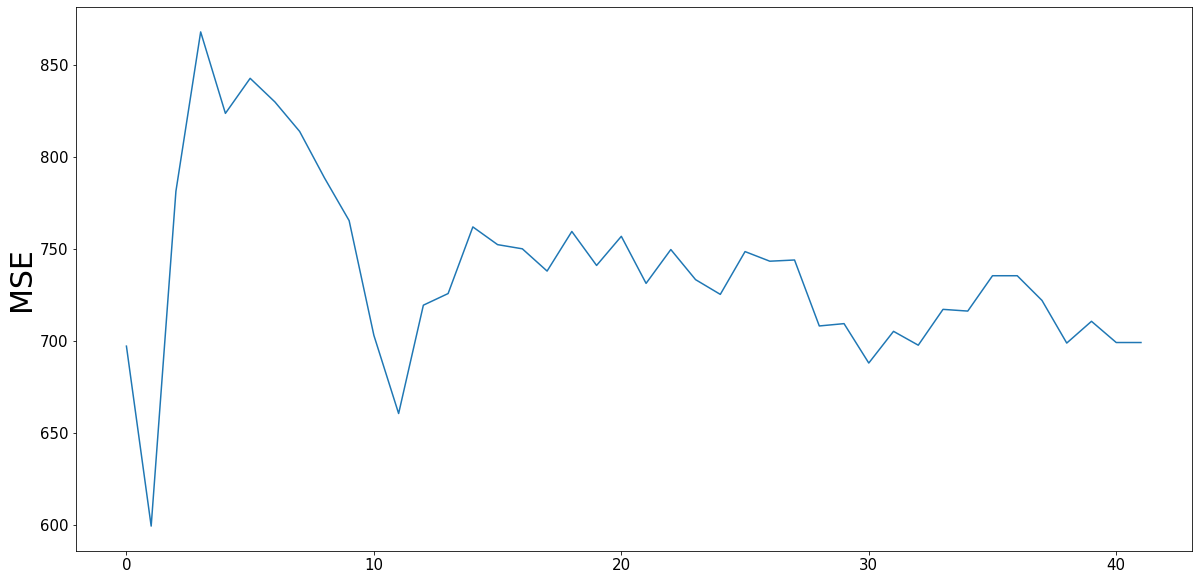

In [228]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [229]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
#I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]
result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)

In [230]:
link

array([[  2, -12],
       [ 22,  -8],
       [ 18,  -3],
       [ 58,  -4],
       [ 46, -11],
       [ 38,  -8],
       [ 54,  -6],
       [  0, -11],
       [  8, -12],
       [ 17,  -7],
       [ 29, -10],
       [ 39, -10],
       [ 67,  -9],
       [ 52,  -7],
       [ 49,  -6],
       [ 75,  -4],
       [ 34, -11],
       [  6,  -5],
       [ 10,  -7],
       [ 57,  -6],
       [ 71,  -6],
       [ 67,  -6],
       [ 14,  -3]])

In [231]:
min(result)

581.6202714184957

In [232]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0

Text(0, 0.5, 'MSE')

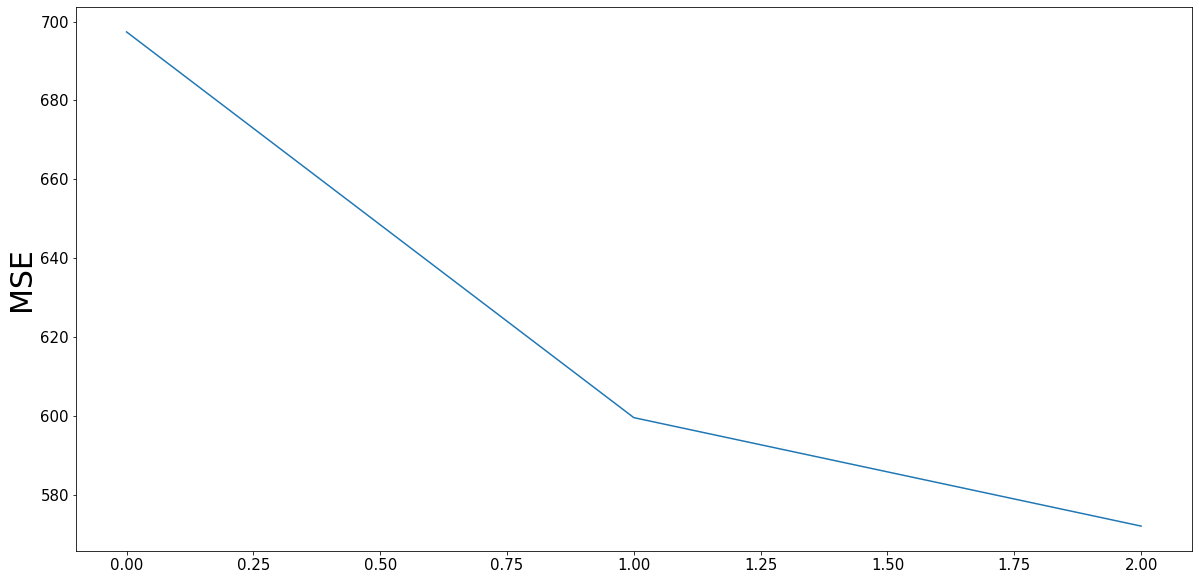

In [233]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [234]:
overall_min_MSE

[599.5649358526301,
 556.6991644573201,
 548.8440204325321,
 572.0614610029984,
 572.0614610029984]

In [235]:
min(overall_min_MSE)

548.8440204325321

In [236]:
np.argmin(overall_min_MSE)

2

In [237]:
best_links = link_list[np.argmin(overall_min_MSE)-1]

In [244]:
for z in range(len(best_links)):
 #   df = pd.DataFrame({"drought":count, "drought1":count})
 #   df.drought1 = df.drought1.shift(abs(tau))
    df = pd.DataFrame({"drought":count})

    for k in range(0,z+1):
            if best_links[k,0] != 0:
                df[str(best_links[k,0]-1)] = result_sst[:,best_links[k,0]-1]
                df[str(best_links[k,0]-1)] = df[str(best_links[k,0]-1)].shift(abs(best_links[k,1]))
            else:
                df[str(best_links[k,0])] = count
                df[str(best_links[k,0])] = df[str(best_links[k,0])].shift(abs(best_links[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

In [239]:
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))

In [71]:
df[7] = result_sst[:,7]
df[7] = df[7].shift(12)

In [72]:
df[66] = result_sst[:,66]
df[66] = df[66].shift(12)

In [73]:
df = df.dropna()

In [74]:
index = int(df.shape[0]*0.7)
dim = df.shape[1]

In [75]:
x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

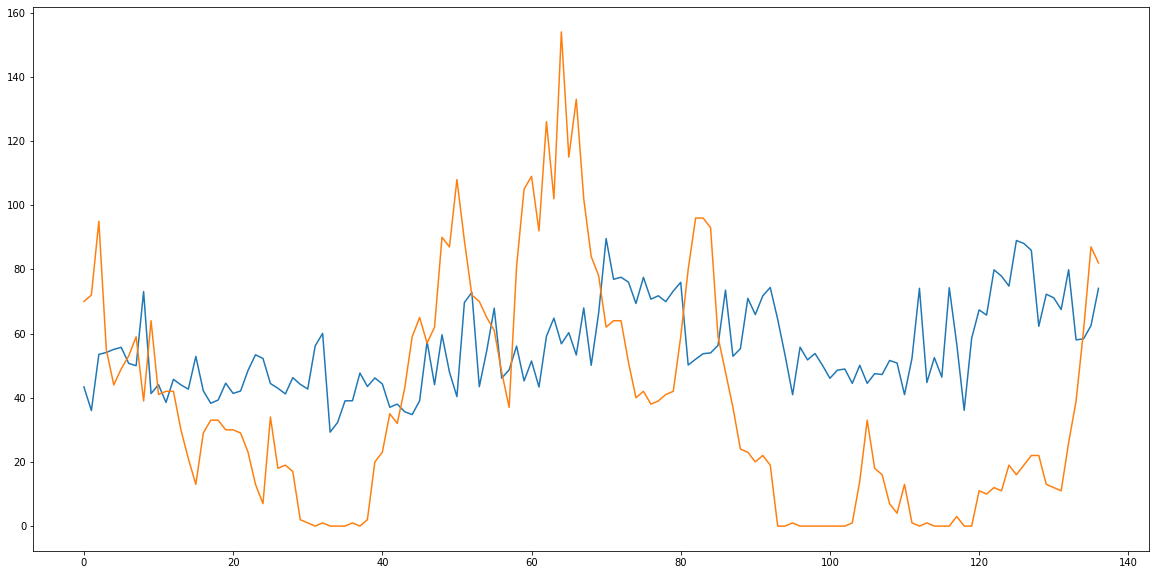

In [245]:
x = range(len(y_pred))

plt.plot(x,y_pred)
plt.plot(x,y_test)

In [200]:
n_components_sst = 76


sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_raw = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_raw))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)


#scale = StandardScaler()
#scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(data_sst)
df_cluster_sst = pca_model.transform(data_sst)


#Matrix = pd.DataFrame(np.transpose(pca_model.components_))
#Matrix = (Matrix - Matrix.mean())/Matrix.std()
loading_sst = pf.varimax(np.transpose(pca_model.components_), q=1000)
for z in range(loading_sst.shape[1]):
    loading_sst[:,z] = loading_sst[:,z] / np.linalg.norm(loading_sst[:,z])
loading_sst = pd.DataFrame(loading_sst)

#Matrix = np.transpose(pca_model.components_)
#loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))


clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [201]:
def time_series_maker(pc, df_sst, result): 
    limit = np.percentile(df_sst.pc.values, 95)
    d = df_sst[df_sst.pc > limit]
    d = result[:,d.index].mean(axis=1)
    d = np.ravel(d)
    d = np.reshape(d,(len(d),1))
    d = pf.deseasonalize(d)
    d = np.ravel(d)
    return(d)

In [242]:
for z in range(len(best_links)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(0,z+1):
            if best_links[k,0] != 0:
                pc = best_links[k,0]-1
                df_sst["pc"] = loading_sst[pc]           
                df[str(best_links[k,0]-1)] = time_series_maker(pc, df_sst, result_raw)
                df[str(best_links[k,0]-1)] = df[str(best_links[k,0]-1)].shift(abs(best_links[k,1]))
            else:
                df[str(best_links[k,0])] = count
                df[str(best_links[k,0])] = df[str(best_links[k,0])].shift(abs(best_links[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

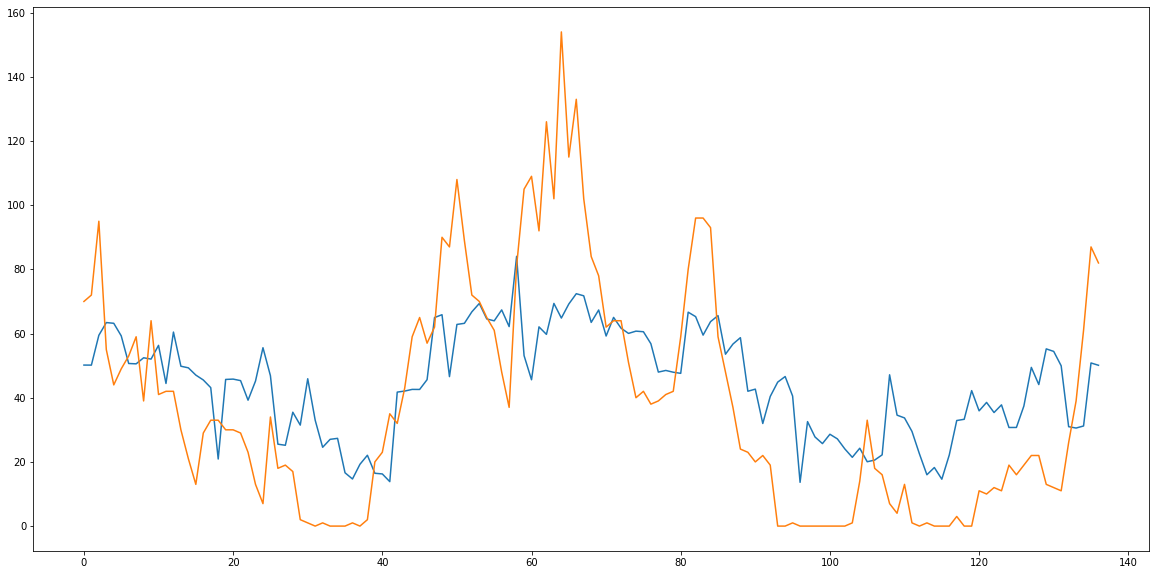

In [243]:
x = range(len(y_pred))

plt.plot(x,y_pred)
plt.plot(x,y_test)

# Second Approach

In [44]:
pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)


n_estimators=100
max_depth=100
tau = -12

In [45]:
link = np.array(link_dict[0])
link = link[1:,: ]

Text(0, 0.5, 'MSE')

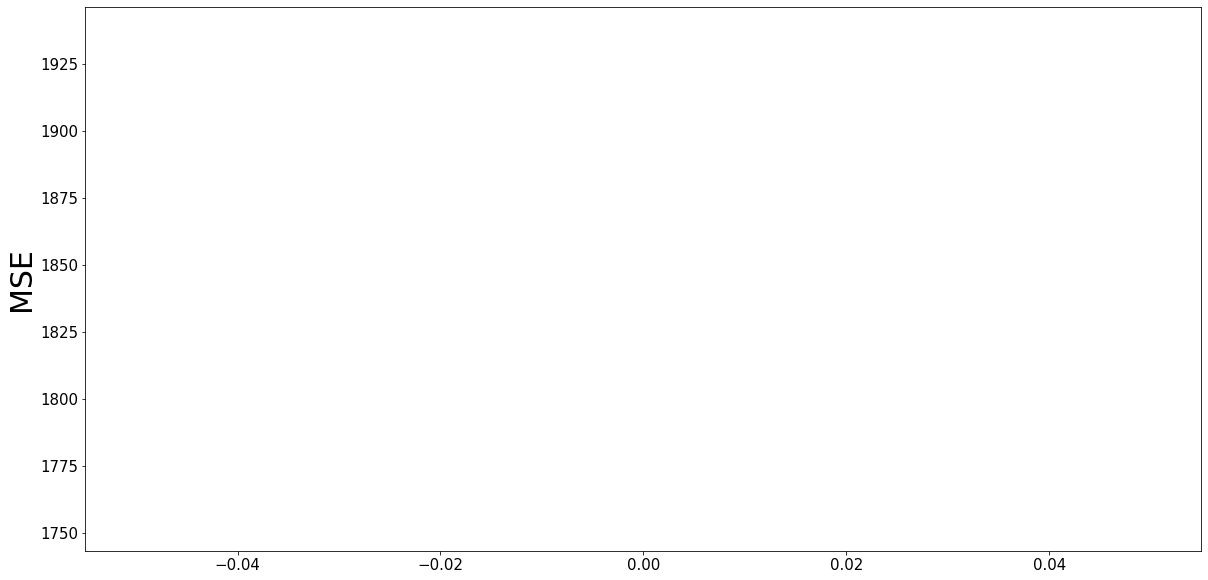

In [46]:
#np.random.shuffle(link[1:,:])

result, refined_link = min_MSE_finder1(count, result_sst, link,n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [47]:
min(result)

1844.81350162194

In [48]:
refined_link

array([], dtype=float64)

In [56]:
result

[1403.9484683246249,
 992.3122758008374,
 987.6159249495914,
 879.4992787013271,
 878.9826553311506,
 866.1072474052465,
 825.3225672676634,
 810.5792175855954,
 765.211163541713]

array([[  2, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 38,  -8],
       [ 54,  -6],
       [ 14,  -6],
       [  5,  -8],
       [ 33,  -8]])

Text(0, 0.5, 'MSE')

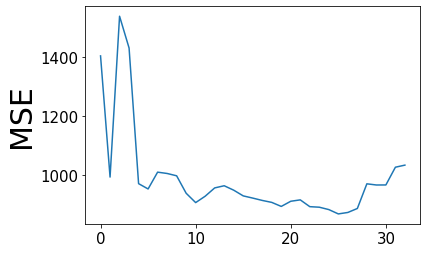

In [15]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [16]:
min(result)

867.1539408850756

In [41]:
np.array(refined_link)

array([[  2, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 14,  -6],
       [  5,  -8],
       [ 33,  -8],
       [ 71,  -6]])

In [37]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder(count, result_sst, link,n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0 

Text(0, 0.5, 'MSE')

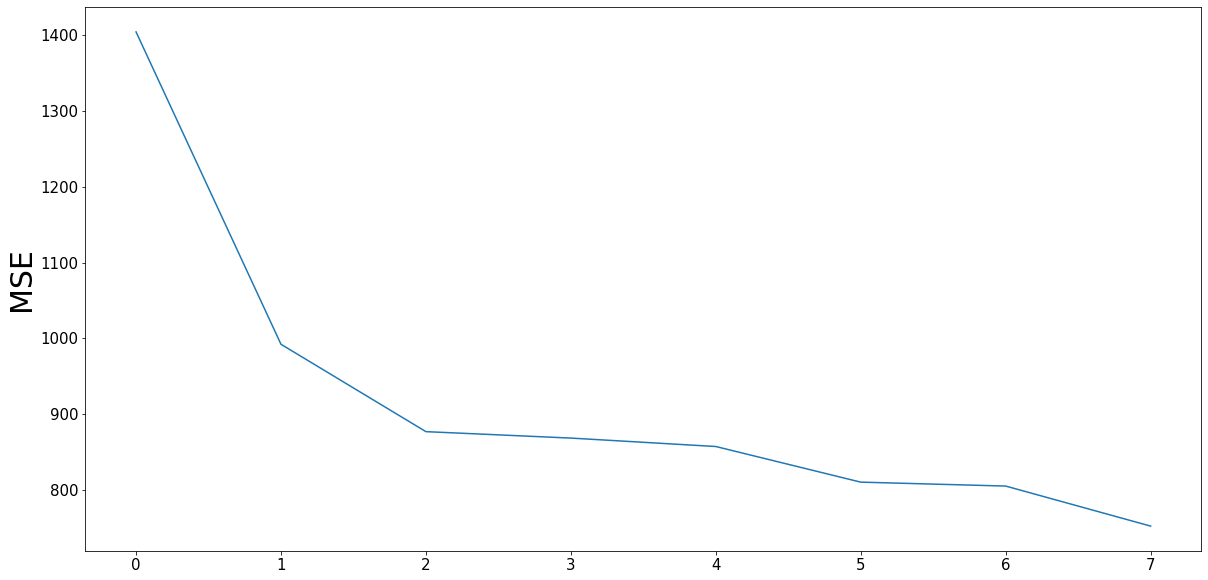

In [38]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [39]:
min(result)

752.7073589035881

In [40]:
overall_min_MSE

[887.7456114211551, 846.5992239394999, 797.4893528102945, 752.7073589035881]

Text(0, 0.5, 'MSE')

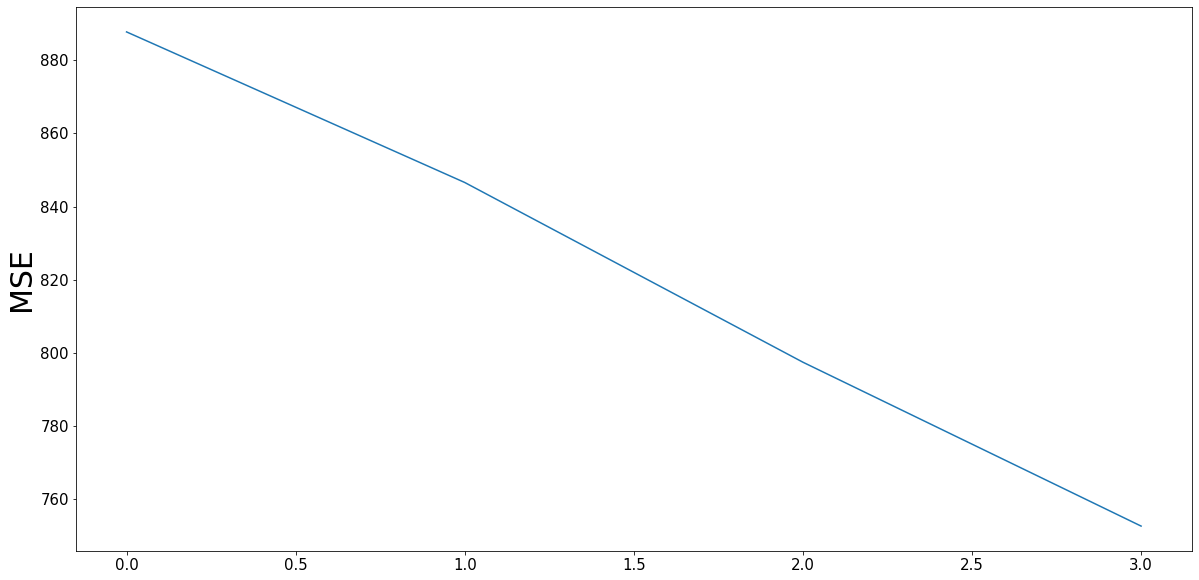

In [41]:
plt.plot(overall_min_MSE)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [42]:
link_list

[array([[  2, -12],
        [  0, -12],
        [ 72, -11],
        [ 22,  -8],
        [ 52, -10],
        [ 46, -11],
        [ 38,  -8],
        [ 54,  -6],
        [  0, -11],
        [ 14,  -6],
        [ 43, -11],
        [  8, -12],
        [ 17,  -7],
        [ 29, -10],
        [  5,  -8],
        [ 39, -10],
        [ 70,  -6],
        [ 67,  -9],
        [ 52,  -7],
        [ 49,  -6],
        [ 67, -12],
        [ 34, -11],
        [ 48, -10],
        [ 10,  -7],
        [ 33,  -8],
        [ 57,  -6],
        [ 72,  -6],
        [  1, -10],
        [ 71,  -6],
        [ 67,  -6],
        [ 21,  -7],
        [  2, -11]]), array([[  2, -12],
        [ 72, -11],
        [ 22,  -8],
        [ 52, -10],
        [ 38,  -8],
        [ 54,  -6],
        [  0, -11],
        [ 14,  -6],
        [ 29, -10],
        [  5,  -8],
        [ 39, -10],
        [ 70,  -6],
        [ 67,  -9],
        [ 52,  -7],
        [ 34, -11],
        [ 10,  -7],
        [ 33,  -8],
        [ 72,  -6],

In [22]:
link_list[3]

array([[  2, -12],
       [ 72, -11],
       [ 22,  -8],
       [ 38,  -8],
       [ 54,  -6],
       [ 14,  -6],
       [  5,  -8],
       [ 70,  -6],
       [ 33,  -8],
       [ 71,  -6]])

In [37]:
refined_link

[array([  2, -12]),
 array([ 72, -11]),
 array([22, -8]),
 array([14, -6]),
 array([ 5, -8]),
 array([33, -8]),
 array([71, -6])]

In [94]:
result =[]
tau = -6
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(1,len(link_dict[0])):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(1,z+1):
        if link_dict[0][k][1] <= tau:
            if link_dict[0][k][0] != 0 and link_dict[0][k][1] >= tau:
                df[str(link_dict[0][k][0]-1)] = result_sst[:,link_dict[0][k][0]-1]
                df[str(link_dict[0][k][0]-1)] = df[str(link_dict[0][k][0]-1)].shift(abs(link_dict[0][k][1]))
            else:
                df[str(link_dict[0][k][0])] = count
                df[str(link_dict[0][k][0])] = df[str(link_dict[0][k][0])].shift(abs(link_dict[0][k][1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))

In [95]:
result

[1313.9073603912718,
 1311.4194559682414,
 1312.4432841387338,
 1312.4432841387338,
 1511.7432959280677,
 1497.3371557905002,
 1464.152396888303,
 1464.152396888303,
 1464.152396888303,
 1461.2927342714834,
 1475.5046532109288,
 1365.8259815568347,
 1365.8259815568347,
 1374.918484710145,
 1299.6950531599193,
 1287.0852062383813,
 1287.0852062383813,
 1296.204703816903,
 1295.5091182455192,
 1287.4078152307645,
 1287.4078152307645,
 1304.6673497970792,
 1295.0569970322526,
 1281.6032415124873,
 1290.67760570931,
 1290.67760570931,
 1290.67760570931,
 1290.67760570931,
 1290.67760570931,
 1286.3900736159271,
 1286.3900736159271,
 1273.5049326640114,
 1271.0798677971604,
 1271.0798677971604,
 1271.0798677971604,
 1263.127318383746,
 1269.7597639046576,
 1269.7597639046576,
 1269.7597639046576,
 1265.2645344184264,
 1265.2645344184264,
 1286.7779595802592,
 1286.7779595802592,
 1286.7779595802592,
 1242.106192429358,
 1245.7240740823531,
 1245.4913114257033,
 1131.7304163678307,
 1147.062

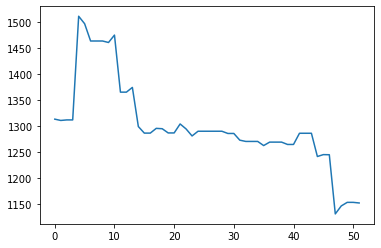

In [96]:
plt.plot(result)

In [116]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]

In [117]:
result =[]
tau = -6
df = pd.DataFrame({"drought":count, "drought1":count})
df.drought1 = df.drought1.shift(abs(tau))
df = df.dropna()
index = int(df.shape[0]*0.7)
dim = df.shape[1]

x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
result.append(mean_squared_error(y_pred, y_test))

for z in range(1,len(link)):
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    for k in range(1,z+1):
        if link[k,0] != 0:
            df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
            df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
        else:
            df[str(link[k,0])] = count
            df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    
    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))

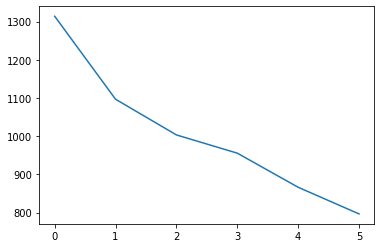

In [118]:
plt.plot(result)

In [119]:
link

array([[  0,  -1],
       [  2, -12],
       [ 22,  -8],
       [ 54,  -6],
       [ 14,  -6],
       [ 71,  -6]])

In [121]:
28/303

0.0924092409240924

In [9]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.439

    Variable SST_0 has 2 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.703
        (SST_49 -8): pval = 0.00000 | qval = 0.00709 | val = -0.254

    Variable SST_1 has 1 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.602

    Variable SST_2 has 1 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.605

    Variable SST_3 has 1 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.549

    Variable SST_4 has 2 link(s):
        (SST_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.425
        (SST_1 -9): pval = 0.00002 | qval = 0.02361 | val = -0.239

    Variable SST_5 has 1 link(s):
        (SST_5 -1): pval = 0.00000 | qval = 0.00000 | val = 0.546

    Variable SST_6 has 1 link(s):
        (SST_6 -1): pval = 0.00000 | qval = 0.00000 | val = 0.538

    Var

In [36]:
name = ["../../nc/precip.mon.total.2.5x2.5.v2018.nc"]
code = ["precip"]
missing = [-9.96921e+36]
n_components = [87]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

precip_name  = []
for i in range(n_components[0]):
    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + precip_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pre = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pre), axis=1)
result = np.array(result)

In [37]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [39]:
results = load_obj("results_pre")

q_matrix = np.load("q_matrix_pre.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 68 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.589
        (PRECIP_3 -1): pval = 0.00037 | val = -0.226
        (PRECIP_71 -6): pval = 0.00166 | val = 0.201
        (PRECIP_2 -1): pval = 0.00161 | val = -0.201
        (PRECIP_0 -1): pval = 0.00282 | val = -0.185
        (PRECIP_6 -1): pval = 0.00355 | val = -0.184
        (PRECIP_6 -8): pval = 0.00438 | val = -0.183
        (PRECIP_51 -11): pval = 0.00537 | val = -0.181
        (PRECIP_70 -1): pval = 0.00613 | val = -0.177
        (PRECIP_54 -5): pval = 0.00732 | val = 0.173
        (PRECIP_8 -6): pval = 0.00733 | val = -0.172
        (PRECIP_22 -7): pval = 0.00895 | val = 0.170
        (PRECIP_31 -5): pval = 0.00825 | val = -0.170
        (PRECIP_23 -2): pval = 0.00846 | val = -0.168
        (PRECIP_46 -11): pval = 0.01001 | val = -0.167
        (PRECIP_52 -3): pval = 0.01023 | val = 0.167
        (PRECIP_41 -7): pval = 0.01090 | val = -0.166
        (P

In [8]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.589

    Variable PRECIP_0 has 0 link(s):

    Variable PRECIP_1 has 0 link(s):

    Variable PRECIP_2 has 0 link(s):

    Variable PRECIP_3 has 0 link(s):

    Variable PRECIP_4 has 0 link(s):

    Variable PRECIP_5 has 0 link(s):

    Variable PRECIP_6 has 0 link(s):

    Variable PRECIP_7 has 0 link(s):

    Variable PRECIP_8 has 0 link(s):

    Variable PRECIP_9 has 0 link(s):

    Variable PRECIP_10 has 0 link(s):

    Variable PRECIP_11 has 0 link(s):

    Variable PRECIP_12 has 0 link(s):

    Variable PRECIP_13 has 0 link(s):

    Variable PRECIP_14 has 1 link(s):
        (PRECIP_86 -10): pval = 0.00000 | qval = 0.00601 | val = 0.345

    Variable PRECIP_15 has 0 link(s):

    Variable PRECIP_16 has 0 link(s):

    Variable PRECIP_17 has 0 link(s):

    Variable PRECIP_18 has 0 link(s):

    Variable PRECIP_19 has 0 link(s):

    Vari

In [12]:
name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

#pres_name  = []
#for i in range(n_components[0]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + sat_name
#

result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_sat = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_sat), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = load_obj("results_sat")

q_matrix = np.load("q_matrix_sat.npy")

In [15]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)




## Significant links at alpha = 0.05:

    Variable n_extremes has 52 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.501
        (SAT_22 -2): pval = 0.00021 | val = 0.223
        (SAT_59 -6): pval = 0.00041 | val = -0.215
        (SAT_64 -12): pval = 0.00160 | val = 0.196
        (SAT_38 -2): pval = 0.00368 | val = -0.179
        (SAT_52 -4): pval = 0.00398 | val = 0.178
        (SAT_13 -5): pval = 0.00572 | val = 0.174
        (SAT_62 -1): pval = 0.00624 | val = -0.169
        (SAT_63 -3): pval = 0.00815 | val = 0.162
        (SAT_80 -4): pval = 0.01095 | val = -0.160
        (SAT_14 -1): pval = 0.00861 | val = 0.160
        (SAT_29 -6): pval = 0.01090 | val = 0.159
        (SAT_49 -8): pval = 0.01192 | val = -0.155
        (SAT_66 -6): pval = 0.01544 | val = -0.152
        (SAT_35 -1): pval = 0.01409 | val = -0.152
        (SAT_52 -8): pval = 0.01579 | val = 0.151
        (SAT_55 -7): pval = 0.01798 | val = 0.148
        (SAT_24 -6): pval = 0.01680 | val = 0.146
        

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.501

    Variable SAT_0 has 1 link(s):
        (SAT_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.630

    Variable SAT_1 has 2 link(s):
        (SAT_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.475
        (SAT_43 -3): pval = 0.00000 | qval = 0.00403 | val = 0.298

    Variable SAT_2 has 1 link(s):
        (SAT_2 -1): pval = 0.00000 | qval = 0.01945 | val = 0.280

    Variable SAT_3 has 1 link(s):
        (SAT_3 -1): pval = 0.00000 | qval = 0.02694 | val = 0.282

    Variable SAT_4 has 0 link(s):

    Variable SAT_5 has 0 link(s):

    Variable SAT_6 has 1 link(s):
        (SAT_32 -4): pval = 0.00000 | qval = 0.03322 | val = 0.289

    Variable SAT_7 has 0 link(s):

    Variable SAT_8 has 0 link(s):

    Variable SAT_9 has 0 link(s):

    Variable SAT_10 has 0 link(s):

    Variable SAT_11 has 0 link(s):

    Variable SAT_12 has 0 lin

In [11]:
name = ["../../nc/pres.mon.mean.nc"]
code = ["pres"]
missing = [-9.96921e+36]
n_components = [64]


df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

extremes_name  = ["n_extremes"]

#precip_name  = []
#for i in range(n_components[0]):
#    precip_name.append("PRECIP_%d"%i)

pres_name  = []
for i in range(n_components[0]):
    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[0]):
#    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = extremes_name + pres_name

In [12]:
result_extremes = np.array(count)
result_extremes = result_extremes.reshape((len(count),1))


result_pres = np.array(df_cluster[0])


result = np.concatenate((result_extremes,result_pres), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [14]:
results = load_obj("results_pres")

q_matrix = np.load("q_matrix_pres.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 49 link(s):
        (n_extremes -1): pval = 0.00000 | val = 0.618
        (PRES_25 -10): pval = 0.00007 | val = 0.253
        (PRES_1 -1): pval = 0.00074 | val = -0.207
        (PRES_62 -7): pval = 0.00105 | val = -0.205
        (n_extremes -12): pval = 0.00117 | val = -0.204
        (PRES_11 -2): pval = 0.00265 | val = -0.190
        (PRES_49 -2): pval = 0.00303 | val = -0.178
        (PRES_5 -2): pval = 0.00638 | val = -0.169
        (PRES_24 -1): pval = 0.00653 | val = -0.169
        (PRES_58 -10): pval = 0.00729 | val = -0.169
        (PRES_50 -3): pval = 0.00516 | val = 0.169
        (PRES_57 -2): pval = 0.00686 | val = 0.167
        (PRES_41 -8): pval = 0.00776 | val = 0.166
        (PRES_61 -7): pval = 0.00835 | val = -0.164
        (PRES_62 -8): pval = 0.01142 | val = 0.160
        (PRES_37 -2): pval = 0.01456 | val = 0.153
        (PRES_61 -3): pval = 0.01320 | val = -0.152
        (PRES_49 -10): pval = 0.0134

In [15]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable n_extremes has 1 link(s):
        (n_extremes -1): pval = 0.00000 | qval = 0.00000 | val = 0.618

    Variable PRES_0 has 0 link(s):

    Variable PRES_1 has 0 link(s):

    Variable PRES_2 has 0 link(s):

    Variable PRES_3 has 0 link(s):

    Variable PRES_4 has 0 link(s):

    Variable PRES_5 has 0 link(s):

    Variable PRES_6 has 1 link(s):
        (PRES_53 -9): pval = 0.00000 | qval = 0.01876 | val = -0.306

    Variable PRES_7 has 0 link(s):

    Variable PRES_8 has 0 link(s):

    Variable PRES_9 has 0 link(s):

    Variable PRES_10 has 0 link(s):

    Variable PRES_11 has 0 link(s):

    Variable PRES_12 has 0 link(s):

    Variable PRES_13 has 0 link(s):

    Variable PRES_14 has 0 link(s):

    Variable PRES_15 has 0 link(s):

    Variable PRES_16 has 0 link(s):

    Variable PRES_17 has 0 link(s):

    Variable PRES_18 has 0 link(s):

    Variable PRES_19 has 0 link(s):

    Variable PRES_20 has 0 link(s):

    Variable 

In [7]:
result_spi = np.load("df_cluster_spi.npy")

In [11]:


level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 18

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [12]:
result_sst = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

In [13]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results = load_obj("results_spi")

q_matrix = np.load("q_matrix_spi.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 77 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.588
        (SPI_0 -12): pval = 0.00000 | val = -0.334
        (SPI_2 -12): pval = 0.00000 | val = -0.268
        (SST_1 -7): pval = 0.00051 | val = -0.189
        (SST_1 -12): pval = 0.00061 | val = -0.187
        (SPI_2 -1): pval = 0.00087 | val = -0.184
        (SST_0 -10): pval = 0.00077 | val = 0.184
        (SPI_4 -2): pval = 0.00173 | val = 0.174
        (SST_18 -1): pval = 0.00308 | val = -0.167
        (SST_74 -4): pval = 0.00350 | val = -0.166
        (SST_45 -6): pval = 0.00469 | val = 0.163
        (SPI_2 -3): pval = 0.00405 | val = -0.159
        (SPI_16 -8): pval = 0.00427 | val = -0.159
        (SPI_9 -2): pval = 0.00459 | val = 0.158
        (SST_18 -7): pval = 0.00533 | val = -0.158
        (SPI_14 -9): pval = 0.00636 | val = -0.153
        (SPI_0 -11): pval = 0.00596 | val = 0.152
        (SPI_5 -9): pval = 0.00630 | val = 0.150
        (SST_34 -12):

In [16]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 3 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.588
        (SPI_0 -12): pval = 0.00000 | qval = 0.00000 | val = -0.334
        (SPI_2 -12): pval = 0.00000 | qval = 0.00181 | val = -0.268

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608
        (SPI_1 -12): pval = 0.00000 | qval = 0.00008 | val = -0.298

    Variable SPI_2 has 3 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.618
        (SPI_2 -12): pval = 0.00000 | qval = 0.00457 | val = -0.259
        (SPI_0 -12): pval = 0.00000 | qval = 0.00430 | val = -0.258

    Variable SPI_3 has 5 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.597
        (SPI_3 -12): pval = 0.00000 | qval = 0.00000 | val = -0.417
        (SPI_4 -12): pval = 0.00000 | qval = 0.00003 | val = -0.313
        (SPI_15 -12): pval = 0.00003 | qval = 0.03400 | val = 0.234
        (SPI_

In [7]:
result_spi = np.load("df_cluster_spi.npy")

level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/air.mon.mean.nc"]
code = ["air"]
missing = [-9.96921e+36]
n_components = [82]
spi_components = 18

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

sat_name  = []
for i in range(n_components[0]):
    sat_name.append("SAT_%d"%i)

#sst_name  = []
#for i in range(n_components[0]):
#    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sat_name
#

result_spi = np.array(result_spi)


In [9]:
result_sat = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sat), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

results = load_obj("results_spi_sat")

q_matrix = np.load("q_matrix_spi_sat.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 89 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.617
        (SPI_0 -12): pval = 0.00001 | val = -0.268
        (SPI_2 -12): pval = 0.00005 | val = -0.239
        (SPI_5 -6): pval = 0.00037 | val = -0.208
        (SAT_52 -8): pval = 0.00120 | val = 0.201
        (SAT_40 -8): pval = 0.00121 | val = -0.198
        (SPI_4 -2): pval = 0.00107 | val = 0.193
        (SPI_1 -8): pval = 0.00153 | val = -0.188
        (SAT_38 -2): pval = 0.00202 | val = -0.185
        (SAT_39 -1): pval = 0.00192 | val = 0.183
        (SAT_8 -1): pval = 0.00235 | val = -0.182
        (SAT_33 -2): pval = 0.00353 | val = -0.180
        (SAT_78 -7): pval = 0.00437 | val = -0.173
        (SAT_68 -1): pval = 0.00440 | val = -0.171
        (SAT_22 -10): pval = 0.00615 | val = 0.166
        (SAT_11 -1): pval = 0.00548 | val = -0.166
        (SPI_1 -6): pval = 0.00605 | val = -0.163
        (SAT_49 -12): pval = 0.00757 | val = 0.161
        (SPI_17 -

In [10]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.617
        (SPI_0 -12): pval = 0.00001 | qval = 0.02026 | val = -0.268

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.608
        (SPI_1 -12): pval = 0.00000 | qval = 0.00735 | val = -0.285

    Variable SPI_2 has 3 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.618
        (SPI_2 -12): pval = 0.00001 | qval = 0.04145 | val = -0.253
        (SPI_0 -12): pval = 0.00002 | qval = 0.04868 | val = -0.250

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.603
        (SPI_3 -12): pval = 0.00000 | qval = 0.00003 | val = -0.341

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.600
        (SPI_4 -12): pval = 0.00000 | qval = 0.00005 | val = -0.332

    Variable SPI_5 has 1 link(s):
        (SPI_

In [10]:
result_spi = np.load("df_cluster_spi_global.npy")

In [14]:
level = 12
emporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

name = ["../../nc/sst.mnmean.nc"]
code = ["sst"]
missing = [-9.96921e+36]
n_components = [76]
spi_components = 46

df_cluster = []
for j in range(len(name)):
    d = Data('{}'.format(name[j]),code[j],temporal_limits,missing_value=missing[j])

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    result = deseasonalize(np.array(result))
    weights = np.sqrt(np.abs(np.cos(np.array(lat_list)* math.pi/180)))
    for i in range(len(weights)):
        result[:,i] = weights[i] * result[:,i]

    data = pd.DataFrame(result)

#    scale = StandardScaler()
 #   scaled_data = scale.fit_transform(data)

    pca = PCA(n_components=n_components[j])
    pca_model = pca.fit(data)

    df_cluster.append(pca_model.transform(data))

#extremes_name  = ["n_extremes"]

spi_name  = []
for i in range(spi_components):
    spi_name.append("SPI_%d"%i)

#pres_name  = []
#for i in range(n_components[1]):
#    pres_name.append("PRES_%d"%i)

#sat_name  = []
#for i in range(n_components[2]):
#    sat_name.append("SAT_%d"%i)

sst_name  = []
for i in range(n_components[0]):
    sst_name.append("SST_%d"%i)
#
var_names = spi_name + sst_name
#

result_spi = np.array(result_spi)


In [15]:
result_sst = np.array(df_cluster[0])

result = np.concatenate((result_spi,result_sst), axis=1)
result = np.array(result)

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [16]:
results = load_obj("results_SPI_global")

q_matrix = np.load("q_matrix_SPI_global.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)



pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 95 link(s):
        (SPI_0 -1): pval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | val = -0.306
        (SST_34 -5): pval = 0.00020 | val = -0.207
        (SST_73 -10): pval = 0.00036 | val = 0.196
        (SST_1 -1): pval = 0.00057 | val = 0.185
        (SPI_28 -12): pval = 0.00094 | val = 0.181
        (SST_52 -4): pval = 0.00195 | val = -0.171
        (SPI_41 -7): pval = 0.00243 | val = 0.165
        (SST_4 -7): pval = 0.00327 | val = -0.162
        (SST_64 -2): pval = 0.00449 | val = -0.157
        (SPI_37 -8): pval = 0.00503 | val = 0.152
        (SST_46 -1): pval = 0.00627 | val = -0.151
        (SPI_30 -2): pval = 0.00557 | val = 0.150
        (SPI_33 -11): pval = 0.00560 | val = 0.150
        (SST_11 -8): pval = 0.00729 | val = -0.149
        (SPI_19 -4): pval = 0.00596 | val = 0.148
        (SPI_18 -6): pval = 0.00616 | val = 0.147
        (SPI_34 -12): pval = 0.00673 | val = 0.147
        (SST_64 -

In [17]:
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.05)


## Significant links at alpha = 0.05:

    Variable SPI_0 has 2 link(s):
        (SPI_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.678
        (SPI_0 -12): pval = 0.00000 | qval = 0.00001 | val = -0.306

    Variable SPI_1 has 2 link(s):
        (SPI_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.649
        (SPI_1 -12): pval = 0.00000 | qval = 0.00029 | val = -0.275

    Variable SPI_2 has 4 link(s):
        (SPI_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.661
        (SPI_2 -12): pval = 0.00000 | qval = 0.00001 | val = -0.315
        (SPI_12 -3): pval = 0.00001 | qval = 0.01597 | val = 0.242
        (SPI_36 -12): pval = 0.00003 | qval = 0.02910 | val = 0.227

    Variable SPI_3 has 2 link(s):
        (SPI_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.634
        (SPI_3 -12): pval = 0.00005 | qval = 0.04797 | val = -0.226

    Variable SPI_4 has 2 link(s):
        (SPI_4 -1): pval = 0.00000 | qval = 0.00000 | val = 0.647
        (SPI_4 -12): pval = 0.00000 | qval = 0.00